# Variational Autoencoder

A replication of "Auto-encoding Variational Bayes" (Kingma and Welling, 2013)

In [1]:
import numpy as np
import os
import re
import pandas as pd
import torch
import matplotlib as mpl
import shutil
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
#pip install -U scikit-learn

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn import preprocessing
from sklearn.neighbors.kde import KernelDensity
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import RandomSampler, BatchSampler
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.distributions import Bernoulli
from torch.distributions.normal import Normal
from scipy.stats import norm, bernoulli, rv_histogram, gaussian_kde
from scipy.special import expit, logsumexp
import scipy.io as si
import time

#git+https://github.com/szagoruyko/pytorchviz
#from torchviz import make_dot

## Pytorch setup

In [2]:
dtype = torch.float
%matplotlib notebook

In [3]:
# Set up CUDA
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
dtype = torch.float;
device

device(type='cuda')

### Autoencoder models

In [4]:
def sampleNorm(mu, std, epsilon):
    # reparam trick
    return mu + epsilon.detach() * std

In [5]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalAutoEncoder, self).__init__() 
        self.latent_dim = latent_dim
        self.encoderWb3 = nn.Linear(input_dim, hidden_dim)
        self.encoderWb4 = nn.Linear(hidden_dim, latent_dim)
        self.encoderWb5 = nn.Linear(hidden_dim, latent_dim)
        
    def encoder(self, x, eps):
        h1 = F.tanh(self.encoderWb3(x))
        mu = self.encoderWb4(h1)
        logsig = self.encoderWb5(h1)
        std = (logsig).exp()
        z = sampleNorm(
            mu, 
            std, 
            eps
        )
        
        return mu, std, z
        
    def forward(self, x, eps):
        mu, std, z = self.encoder(x, eps)
        output = self.decoder(z)
        return mu, std, z, output
    
    def decoder(self, z):
        return None
    
    def decoder_distribution(self, output):
        return None
    
    def decoder_loss(self, x, output):
        # decoder loss
        return self.decoder_distribution(output).log_prob(x).sum(dim=-1)
    
    def criterion(self, x, mu, std, z, output):
        encoding = (1 + 2 * std.log() - (mu ** 2) - std ** 2).sum(dim=-1) / 2
        decoding = self.decoder_loss(x, output)
        return -(encoding + decoding)
    
    def evaluate(self, images):
        mu, std, z, output = self.forward(images, torch.rand(torch.Size([self.latent_dim])).to(device))
        loss = model.criterion(images, mu, std, z, output)
        return -loss.mean()

In [6]:
class VariationalAutoEncodeBernoulli(VariationalAutoEncoder):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(VariationalAutoEncodeBernoulli, self).__init__(input_dim, hidden_dim, latent_dim) 
        self.decoderWb1 = nn.Linear(latent_dim, hidden_dim)
        self.decoderWb2 = nn.Linear(hidden_dim, output_dim)
    
    def decoder(self, z):
        # decoder (to Bernoulli parameters)
        h2 = F.tanh(self.decoderWb1(z))
        y = F.sigmoid(self.decoderWb2(h2))
        return y
    
    def decoder_distribution(self, output):
        return Bernoulli(output)

In [7]:
class VariationalAutoEncodeGaussian(VariationalAutoEncoder):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(VariationalAutoEncodeGaussian, self).__init__(input_dim, hidden_dim, latent_dim) 
        self.decoderWb3 = nn.Linear(latent_dim, hidden_dim)
        self.decoderWb4 = nn.Linear(hidden_dim, output_dim)
        self.decoderWb5 = nn.Linear(hidden_dim, output_dim)
        
    def decoder(self, z):
        h2 = F.tanh(self.decoderWb3(z))
        y_mu = self.decoderWb4(h2)
        y_logsig = self.decoderWb5(h2)
        return y_mu, y_logsig
    
    def decoder_distribution(self, output):
        y_logsig, y_mu = output
        y_std = (y_logsig).exp()
        return Normal(F.sigmoid(y_mu), y_std)

## Train plotting code

In [8]:
def plot_sample(im, sample_grid, size):
    showgrid = make_grid(sample_grid, size)
    npgrid = showgrid.cpu().numpy().clip(0,1)
    im.set_data(np.transpose(npgrid, (1,2,0)))

In [9]:
def plot_likelihood(ax, tr_line, te_line, title, tr_losses, te_losses, data_interval):
    ax.set_title(title)
    tr_line.set_data(np.arange(len(tr_losses)) * data_interval, tr_losses)
    te_line.set_data(np.arange(len(te_losses)) * data_interval, te_losses)
    ax.legend()

In [10]:
# manifold for 2D autoencoder or random samples of encoded space for {n}D
def get_sample_zs(Nz):
    if Nz == 2:
        unitline = [0.0001, 0.2, 0.4, 0.6, 0.8, 0.9999]
        unit_square = np.ones((len(unitline),len(unitline), Nz))
        for i in range(len(unitline)):
            for j in range(len(unitline)):
                unit_square[i,j] = norm.ppf((unitline[i], unitline[j]))
    else:
        unit_square = norm.ppf(np.random.rand(6,6,Nz))
    sample_zs = torch.Tensor(unit_square.reshape((-1, Nz)), device=device)
    return sample_zs, unit_square.shape[0]

In [11]:
def save_checkpoint(epoch, model, opt, batch_size, report_interval, tr_losses, te_losses, checkpoint_folder):            
    torch.save({
        'epoch': epoch + 1,
        'tr_loss': tr_losses[-1],
        'te_loss': te_losses[-1],
        'state_dict': model.state_dict(),
        'optimizer' : opt.state_dict(),
    }, os.path.join(checkpoint_folder, 'checkpoint-{0:05d}.pth.tar'.format(epoch)))

    torch.save({
        'batch_size': batch_size,
        'report_interval': report_interval,
        'tr_losses': tr_losses,
        'te_losses': te_losses,
    }, os.path.join(checkpoint_folder, 'losses.pth.tar'))

In [12]:
def load_checkpoint(model, opt, checkpoint_folder):
    if os.path.isdir(checkpoint_folder):
        print("=> found checkpoint '{}'.".format(checkpoint_folder))
        dirFiles = list(filter(lambda f: re.match('checkpoint', f), os.listdir(checkpoint_folder)))
        dirFiles.sort()
        checkpoint = torch.load(os.path.join(checkpoint_folder, dirFiles[-1]))
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        opt.load_state_dict(checkpoint['optimizer'])

        loss_checkpoint = torch.load(os.path.join(checkpoint_folder,'losses.pth.tar'))
        batch_size = loss_checkpoint['batch_size']
        report_interval = loss_checkpoint['report_interval']
        tr_losses = loss_checkpoint['tr_losses'][0:len(dirFiles)]
        te_losses = loss_checkpoint['te_losses'][0:len(dirFiles)]
        print("=> loaded checkpoint '{}' (epoch {})".format(checkpoint_folder, start_epoch))
        return start_epoch, batch_size, report_interval, tr_losses, te_losses
    else:
        print("=> no checkpoint found at '{}'".format(checkpoint_folder))
        os.makedirs(checkpoint_folder)
        return None

## Training harness

In [13]:
def train(
    run_name, 
    model, 
    l_rate, 
    epochs, 
    batch_size, 
    train_images, 
    test_images, 
    image_size, 
    fig, 
    ax, 
    report_interval
):
    train_dataset = TensorDataset(train_images)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    start_epoch = 0
    
    tr_losses = list()
    te_losses = list()
    tr_line, = ax[0].plot([],[], label='Train')
    te_line, = ax[0].plot([],[], label='Test')
    showgrid = make_grid([torch.zeros(torch.Size(image_size)) for z in range(36)],6)
    npgrid = showgrid.cpu().numpy()
    im1 = ax[1].imshow(np.transpose(npgrid, (1,2,0)))
    im2 = ax[2].imshow(np.transpose(npgrid, (1,2,0)))
    opt = torch.optim.Adagrad(model.parameters(), lr = l_rate) 
    
    checkpoint_folder = 'checkpoints/{}'.format(run_name)
    
    loaded_checkpoint = load_checkpoint(model, opt, checkpoint_folder)
    if loaded_checkpoint:
        start_epoch, batch_size, report_interval, tr_losses, te_losses = loaded_checkpoint
    else:
        # Paper uses adagrad and uses normal initializations
        for m in model.parameters():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, 0, 0.01)
                nn.init.normal_(m.bias.data, 0, 0.01)
    
    # samples of latent dimension to visualize
    sample_zs, grid_size = get_sample_zs(model.latent_dim)
    sample_zs = sample_zs.to(device)
    # resusable epsilon value for samples of latent dimension
    sample_eps = torch.rand(torch.Size([36, model.latent_dim]), device=device, dtype=dtype)
    
    for epoch in range(start_epoch, max(start_epoch+1,epochs)):
        it = 0
        for images, in iter(train_loader):
            opt.zero_grad()
            mu, std, z, output = model.forward(
                images, 
                torch.normal(
                    torch.zeros(torch.Size([images.shape[0], model.latent_dim])), 
                    torch.ones(torch.Size([images.shape[0], model.latent_dim]))
                ).to(device)
            )
            
            loss = model.criterion(images, mu, std, z, output).mean()
            loss.backward()
            opt.step()

        if epoch % report_interval == 0 or epoch == epochs - 1:

            # dataset evaluation of ELBO loss
            tr_losses += [model.evaluate(train_images).detach()]
            te_losses += [model.evaluate(test_images).detach()]

            # posterior sample plots
            _, _, resample_zs = model.encoder(test_images[0:36],sample_eps)
            output = (model.decoder(sample_zs))
            resampled_output = (model.decoder(resample_zs))
            
            sample = model.decoder_distribution(output).sample(torch.Size([5])).mean(dim=0).reshape((-1,)+image_size)
            resampled_sample = model.decoder_distribution(resampled_output).sample(torch.Size([5])).mean(dim=0).reshape((-1,)+image_size)
                        
            plot_sample(im1, sample, grid_size)
            plot_sample(im2, resampled_sample, grid_size)
            
            plot_likelihood(
                ax[0], 
                tr_line, 
                te_line, 
                "epoch = {0:d}, ELBO = {1:.4f}/{2:.4f}".format(epoch, tr_losses[-1], te_losses[-1]), 
                tr_losses, 
                te_losses, 
                len(train_images) * report_interval
            )
            
            save_checkpoint(epoch, model, opt, batch_size, report_interval, tr_losses, te_losses, checkpoint_folder)
            
            fig.canvas.draw()
            time.sleep(0.01)
    return model

## MNIST (Bernoulli) example

In [16]:
# Load MNIST
D = 784
binarize_transform = transforms.Lambda(lambda t: torch.where(
   t > torch.Tensor([0.5]), 
   torch.ones(1), 
   torch.zeros(1)
).reshape(D))

# hacky method of getting the entire dataset onto the gpu (mnist is <2GB and will fit on powerful cards)
# if this gives you out-of-memory errors, remove .to(device) on the last lines,
# and move images to the device in each batch in the train harness
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,)), # we are binarizing and don't need the typical normalization
    binarize_transform
]))

mnist_train_loader = DataLoader(
    mnist_train,
    batch_size=len(mnist_train), shuffle=True, pin_memory=True)

mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,)), 
    binarize_transform
]))

mnist_test_loader = DataLoader(
    mnist_test,
    batch_size=len(mnist_test), shuffle=True, pin_memory=True)

Processing...
Done!


In [18]:
mnist_train_images = iter(mnist_train_loader).next()[0].to(device)
mnist_test_images = iter(mnist_test_loader).next()[0].to(device)

<IPython.core.display.Javascript object>


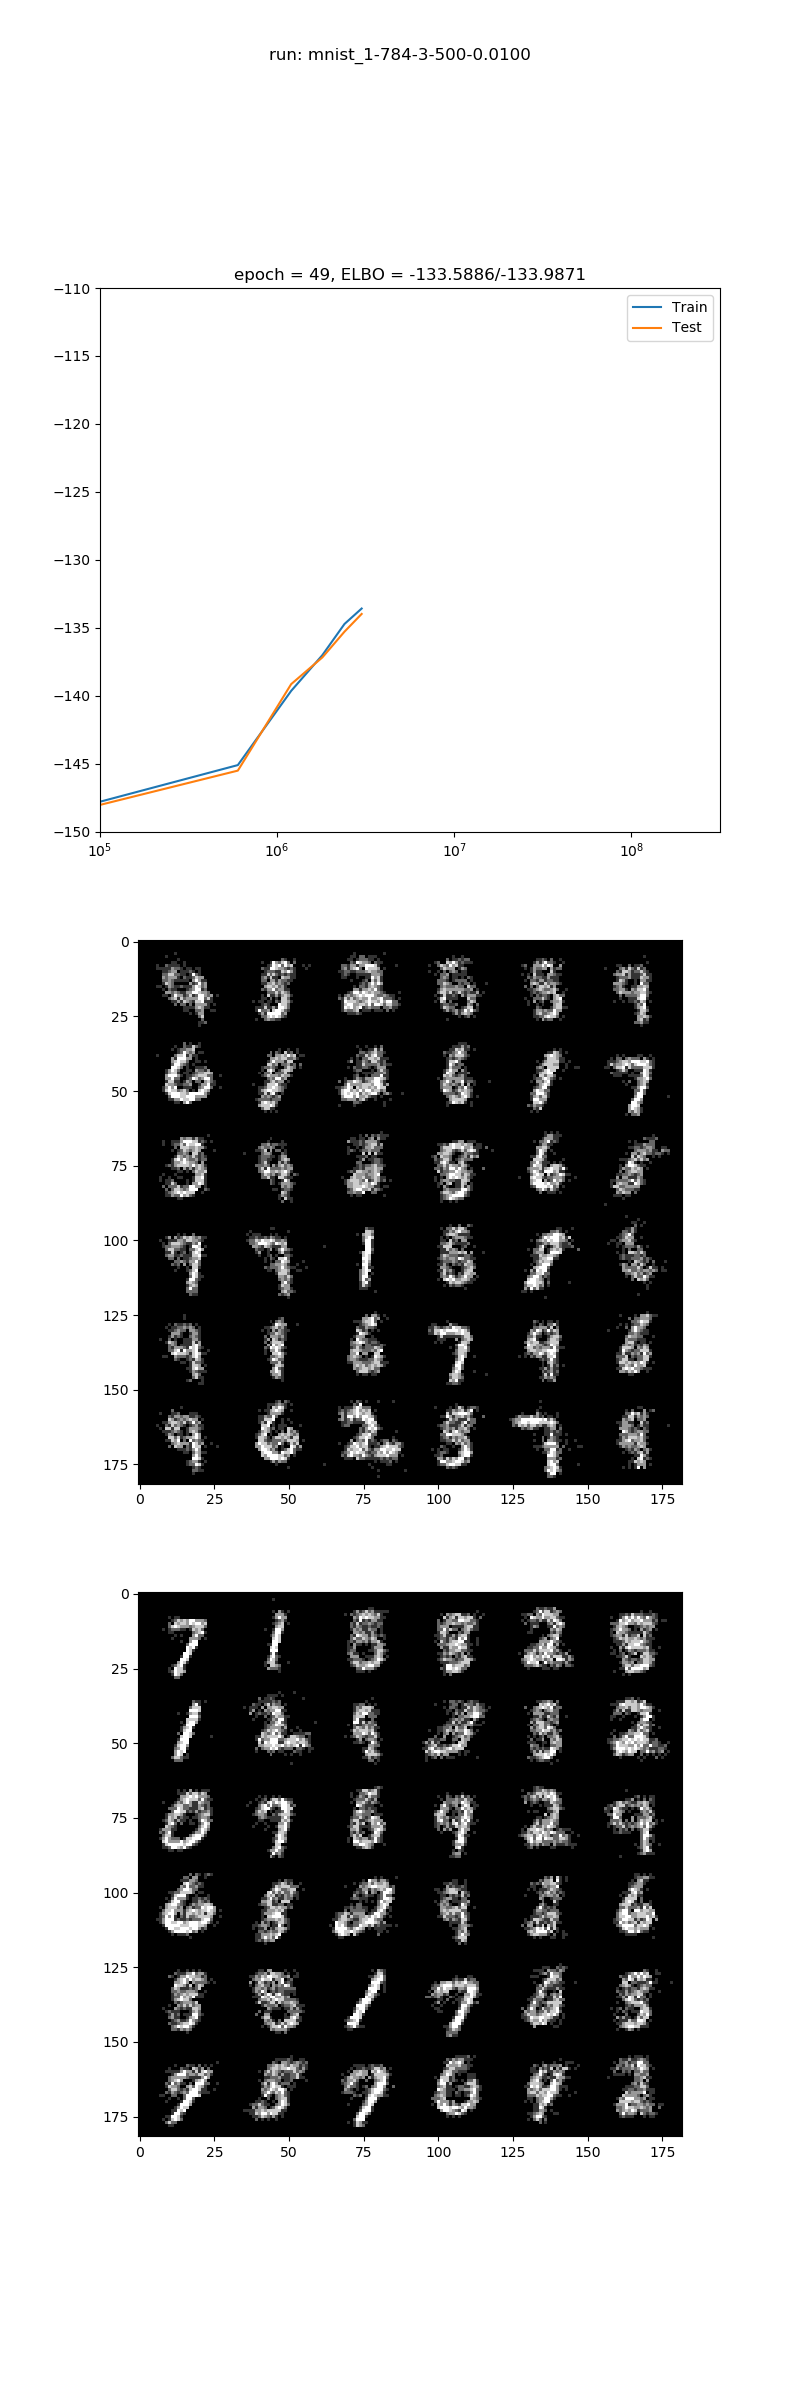

=> found checkpoint 'checkpoints/mnist_1-784-3-500-0.0100'.
=> loaded checkpoint 'checkpoints/mnist_1-784-3-500-0.0100' (epoch 11)


In [20]:
# model parameters
D = 784
Nz = 3
hidden_dim = 500
epochs = 50
l_rate = 0.01
model = VariationalAutoEncodeBernoulli(D, hidden_dim, Nz, D).to(device)
run = 'mnist_1-{0:d}-{1:d}-{2:d}-{3:.4f}'.format(D, Nz, hidden_dim, l_rate)

# plot setup
fig, ax = plt.subplots(3,1,figsize=(8,8))
fig.suptitle('run: {}'.format(run))
ax[0].ticklabel_format(axis='x',style='sci',scilimits=(-3,4))
ax[0].set_xscale("symlog")
ax[0].set_ylim(-150, -110)
ax[0].set_xlim(10**5, 10**8.5)
ax[1].set_aspect(1)
ax[2].set_aspect(1)

mnist_vaeb = train(
    run, 
    model, 
    l_rate, 
    epochs, 
    100, 
    mnist_train_images, 
    mnist_test_images, 
    (1,28,28), 
    fig, 
    ax, 
    10
)

## Frey Faces (Gaussian) Example

In [21]:
# Load Frey Faces
frey_mat = si.loadmat('frey_rawface.mat')
frey_data = torch.from_numpy(frey_mat['ff'].transpose()).float()

# squash data to [0,1]
frey_norm_data = frey_data / frey_data.max() 

#frey_mean = frey_data.mean()
#frey_std = frey_data.std()
#(data - frey_mean) / frey_std
#fig, ax = plt.subplots(1,2)
#ax[0].imshow(data[0].reshape(28,20), cmap='gray')
#ax[1].imshow(norm_data[0].reshape(28,20), cmap='gray')
#plt.show()

# frey face data appears to come ordered and must be shuffled before train/test split
# even batching can seemingly cause overfit because the dataset is so small?
np.random.shuffle(frey_norm_data) 
frey_train_data = frey_norm_data[0:1700]
frey_test_data = frey_norm_data[1700:]

# hacky method of getting the entire dataset onto the gpu (frey is <2MB)#
# if this gives you out-of-memory errors, switch to using frey_train_data and frey_test_data 
# as arguments to train harness and moving to device in each batch
frey_train_loader = DataLoader(frey_train_data, batch_size=len(frey_train_data), shuffle=True)
frey_test_loader = DataLoader(frey_test_data, batch_size=len(frey_test_data), shuffle=True)
frey_train_images = iter(frey_train_loader).next().to(device)
frey_test_images = iter(frey_test_loader).next().to(device)

<IPython.core.display.Javascript object>


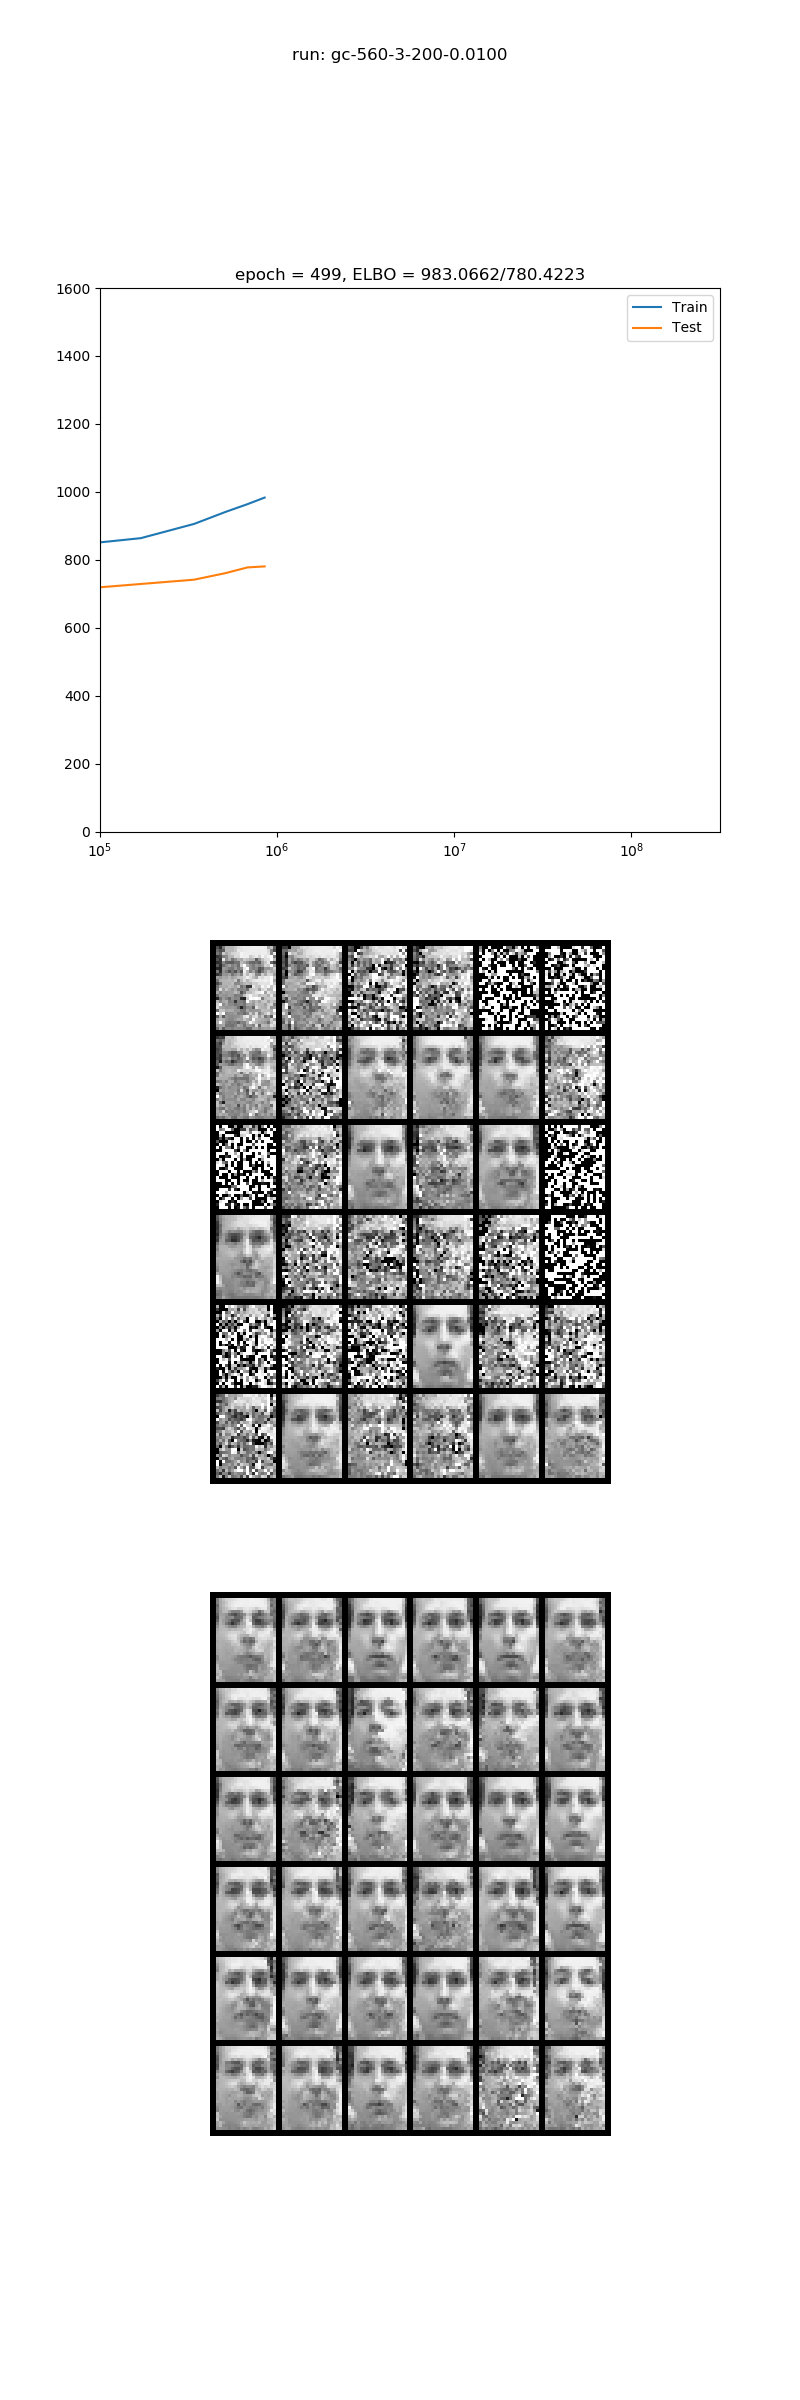

=> found checkpoint 'checkpoints/gc-560-3-200-0.0100'.
=> loaded checkpoint 'checkpoints/gc-560-3-200-0.0100' (epoch 301)


In [29]:
# model parameters
D = 560
Nz = 3
hidden_dim = 200
epochs = 500
l_rate = 0.01

fig, ax = plt.subplots(3,1,figsize=(8,8))
fig.suptitle('run: {}'.format(run))
ax[1].set_axis_off()
ax[2].set_axis_off()
ax[0].ticklabel_format(axis='x',style='sci', scilimits=(0,0))
ax[0].set_xscale("symlog")
ax[0].set_ylim(0, 1600)
ax[0].set_xlim(10**5, 10**8.5)

model = VariationalAutoEncodeGaussian(D, hidden_dim, Nz, D).to(device)
run = 'gc-{0:d}-{1:d}-{2:d}-{3:.4f}'.format(D, Nz, hidden_dim, l_rate)
frey_vaeb = train(
    run_name=run, 
    model=model, 
    l_rate=l_rate, 
    epochs=epochs, 
    batch_size=100, 
    train_images=frey_train_images, 
    test_images=frey_test_images, 
    image_size=(1,28,20), 
    fig=fig, 
    ax=ax, 
    report_interval=100
)

## Monte Carlo sampling

In [30]:
# Notation becomes confusing here because 'x' refers to the hamiltonian position vector
# rather than the autoencoder data vector 
def ham(E, x, v):
    # Hamiltonian of position x and velocity v
    # need to introduce M matrix to leapfrog steps if inner product 
    # other than dot is used here
    # eg we are in some other space
    # v: N x Nz
    return -E(x) + (v*v).sum(dim=-1)*0.5

def leapfrog(x, v, steps, eps, dEdx):
    # partially optimized leapfrog method for Hamiltonian MCMC
    # see e.g. "MCMC using Hamiltonian dynamics" Neal, p. 10
    v -= (eps/2) * dEdx(x) # initial half step
    for i in range(steps-1): # full size steps
        x += eps * v
        v -= eps * dEdx(x)
    x += eps * v # final full step
    v -= (eps/2) * dEdx(x) # final half step
    return x, -v

def hamilton_metropolis(x, v, eps, E, dEdx, phi, steps):
    # Take a Hamiltonian Metropolis-Hastings sample
    # leapfrog to simulate hamiltonian dynamics for a time step
    x_, v_ = leapfrog(x.detach(), v.detach(), steps, eps, dEdx) 
    # probability of accepting proposed move
    accept = (
        torch.rand(torch.Size([x.shape[0]]), requires_grad=False).to(device)
        < torch.min(
            torch.ones(x.shape[0], requires_grad=False).to(device), 
            torch.exp(ham(E, x, v) - ham(E, x_, v_))
        )
    ).float().reshape(-1,1)
    # accept move (or reject and reverse velocity)
    out_x = x_*accept + x*(1-accept)
    out_v = v_*accept + v*(1-accept)
    
    # resample velocity and interpolate if sin(phi) > 0
    out_v = torch.cos(phi) * torch.randn_like(out_v, requires_grad=False).to(device) + torch.sin(phi) * out_v
    return (out_x, -out_v, accept.reshape(-1))

In [31]:
def plot2d(title, samples, fig, ax):
    # plot the first two dimensions of a HMC sample in the plane
    ax.clear()
    ax.set_title(title)
    #ax.contourf(x,y,contourZ(pos), 20, cmap=plt.cm.bone)
    ax.plot(samples[:,:,0], samples[:,:,1], color='red', alpha = 0.05)
    ax.scatter(samples[:,:,0], samples[:,:,1], color='red', alpha = 0.2, s=0.3)
    fig.canvas.draw()
    time.sleep(0.01)

In [32]:
torch.manual_seed(12345)

def get_model_prob(model, z, x):
    # get posterior log prob from latent sample
    output = model.decoder(z)
    log_prob = model.decoder_loss(x, output)
    return log_prob

def get_model_energy(model, z, x):
    # get posterior log prob from latent sample
    output = model.decoder(z)
    log_prob = model.decoder_loss(x, output)
    return -log_prob

def get_model_posterior(model, z, x):
    # get posterior log prob from latent sample
    output = model.decoder(z)
    log_prob = model.decoder_loss(x, output)
    prior = Normal(
        torch.zeros_like(z), 
        torch.ones_like(z)
    ).log_prob(z)
    return (log_prob+prior.sum(dim=-1))

def get_model_energy_grad(model, z, x):
    # get posterior log prob gradident w.r.t a latent sample
    zd = z.detach()
    zd.requires_grad = True
    log_prob = get_model_energy(model, zd, x)
    if zd.grad is not None:
        zd.grad.data.zero_()
        
    log_prob.backward(torch.ones(1, device=device), retain_graph=True)
    log_prob_grad = zd.grad
    
    return log_prob_grad

In [33]:
def sample_posterior(model, x, L, steps, eps, phi, doplot, image_size):
    # sample the model posterior with hybrid monte carlo
    samples = torch.zeros(torch.Size((L,x.shape[0],model.latent_dim)), requires_grad=False).to(device)
    velocities = torch.zeros(torch.Size((L,x.shape[0],model.latent_dim)), requires_grad=False).to(device)
    accepts = torch.zeros(torch.Size((L,x.shape[0])), requires_grad=False).to(device)
    likelihoods = torch.zeros(torch.Size((L,x.shape[0])), requires_grad=False).to(device)
    
    samples[0] = torch.normal(
        torch.zeros(torch.Size((x.shape[0], model.latent_dim,)), requires_grad=False), 
        torch.ones(torch.Size((x.shape[0], model.latent_dim,)), requires_grad=False)
    )
    velocities[0] = torch.normal(
        torch.zeros(torch.Size((x.shape[0], model.latent_dim,)), requires_grad=False), 
        torch.ones(torch.Size((x.shape[0], model.latent_dim,)), requires_grad=False)
    )
    if doplot:
        fig, ax = plt.subplots(4,1, figsize=(8,8))
        showgrid = make_grid([torch.zeros(torch.Size(image_size), requires_grad=False) for z in range(36)],6)
        npgrid = showgrid.cpu().numpy()
        im1 = ax[2].imshow(np.transpose(npgrid, (1,2,0)))
        ax[3].set_ylim(-0.1,1.1)
        sc = ax[3].scatter([],[], s=0.1)
        #ax3 = fig.add_subplot(211, projection='3d')
    
    E = lambda z: (get_model_energy(model, z, x))
    dEdz = lambda z: (get_model_energy_grad(model, z, x))
    
    for n in np.arange(1,L):
        samples[n], velocities[n], accepts[n] = hamilton_metropolis(
            samples[n-1], 
            velocities[n-1], 
            eps,
            E,
            dEdz,
            phi,
            steps
        )
        likelihoods[n] = get_model_posterior(model, samples[n], x)
        if doplot and n % 99 == 0:
            fig.suptitle("paccept = {}".format(accepts[:n].mean()))
            plot2d("", samples[:n].detach().cpu().numpy(), fig, ax[1])
            ax[0].clear()
            ax[0].plot(np.arange(n), -likelihoods[:n].detach().cpu().numpy())
            ax[2].clear()
            ax[3].set_xlim(0,n)
            sc.set_offsets(np.stack((np.arange(n), accepts[:n].mean(dim=-1).detach().cpu().numpy())).T)
            output = (model.decoder(samples[n]))
            sample = model.decoder_distribution(output).sample(torch.Size([5])).mean(dim=0).reshape((-1,)+image_size)
            plot_sample(im1,sample[0:36],6)
        
    return samples, likelihoods, accepts.mean()

## Monte Carlo EM

In [38]:
def train_mcem(run_name, model, l_rate, eps_l_rate, epochs, batch_size, train_images, test_images, image_size, fig, ax, report_interval):
    train_dataset = TensorDataset(train_images)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    start_epoch = 0
    tr_losses = list()
    te_losses = list()
    
    tr_line, = ax[0].plot([],[], label='Train')
    te_line, = ax[0].plot([],[], label='Test')
    showgrid = make_grid([torch.zeros(torch.Size(image_size)) for z in range(36)],6)
    npgrid = showgrid.cpu().numpy()
    im1 = ax[1].imshow(np.transpose(npgrid, (1,2,0)))
    im2 = ax[2].imshow(np.transpose(npgrid, (1,2,0)))
    
    eps = torch.Tensor([2]).to(device)
    eps.requires_grad = True
    target_accept = torch.Tensor([0.9]).to(device)
    
    checkpoint_folder = 'checkpoints/{}'.format(run_name)
    opt = torch.optim.Adagrad(model.parameters(), lr = l_rate) 
    eps_opt = torch.optim.Adagrad([eps], lr = eps_l_rate)
    dirFiles = []
    
    if os.path.isdir(checkpoint_folder):
        print("=> found checkpoint '{}'.".format(run_name))
        dirFiles = list(filter(lambda f: re.match('checkpoint', f), os.listdir(checkpoint_folder)))
        dirFiles.sort()
    if len(dirFiles) > 0:
        checkpoint = torch.load(os.path.join(checkpoint_folder, dirFiles[-1]))
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        opt.load_state_dict(checkpoint['optimizer'])

        loss_checkpoint = torch.load(os.path.join(checkpoint_folder,'losses.pth.tar'))
        tr_losses = loss_checkpoint['tr_losses'][0:len(dirFiles)]
        te_losses = loss_checkpoint['te_losses'][0:len(dirFiles)]
        print("=> loaded checkpoint '{}' (epoch {})".format(checkpoint_folder, start_epoch))
        #return
    else:
        print("=> no checkpoint found at '{}'".format(run_name))
        os.makedirs(checkpoint_folder, exist_ok=True)
    
    
    # Paper uses adagrad and uses normal initializations
    for m in model.parameters():
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight.data, 0, 0.01)
            nn.init.normal_(m.bias.data, 0, 0.01)
    
    # samples of latent dimension to visualize
    sample_zs, grid_size = get_sample_zs(model.latent_dim)
    sample_zs = sample_zs.to(device)
    # resusable epsilon value for samples of latent dimension
    sample_eps = torch.rand(torch.Size([36, model.latent_dim]), device=device, dtype=dtype)
    phi = torch.Tensor([3.14159/4]).to(device)


    for epoch in range(start_epoch, max(start_epoch+1,epochs)):
        accept = None
        for images, in iter(train_loader):
            eps_opt.zero_grad()
            samples, likelihood, accept = sample_posterior(model, images, 50, 10, eps, phi, False, (1,28,28))
            eps_loss = (target_accept-accept)
            eps.grad = eps_loss
            eps_opt.step()
            for i in range(5):
                opt.zero_grad()
                output = model.decoder(samples[-1].detach())
                loss = -model.decoder_loss(images, output).mean()
                loss.backward()
                opt.step()
        if epoch % report_interval == 0 or epoch == epochs - 1:
            
            # dataset evaluation of ELBO loss
            tr_losses += [model.evaluate(train_images).detach()]
            te_losses += [model.evaluate(test_images).detach()]

            _, _, resample_zs = model.encoder(test_images[0:36],sample_eps)
            output = (model.decoder(sample_zs))
            sample = model.decoder_distribution(output).sample(torch.Size([5])).mean(dim=0).reshape((-1,)+image_size)
            
            resampled_output = (model.decoder(resample_zs))
            resampled_sample = model.decoder_distribution(resampled_output).sample(torch.Size([5])).mean(dim=0).reshape((-1,)+image_size)
                        
            plot_sample(im1, sample, grid_size)
            plot_sample(im2, resampled_sample, grid_size)
            fig.suptitle("Epsilon: {}, Accept: {}".format(eps, accept))
            plot_likelihood(
                ax[0], 
                tr_line, 
                te_line, 
                "epoch = {0:d}, ELBO = {1:.4f}/{2:.4f}".format(epoch, tr_losses[-1], te_losses[-1]), 
                tr_losses, 
                te_losses, 
                len(train_images) * report_interval
            )
            
            save_checkpoint(epoch, model, opt, batch_size, report_interval, tr_losses, te_losses, checkpoint_folder)
            
            ax[1].set_aspect(1)
            ax[2].set_aspect(1)
            fig.canvas.draw()
            time.sleep(0.01)
    return model

In [39]:
# Reload MNIST for EM
D=784
em_mnist_train_loader = DataLoader(
    mnist_train,
    batch_size=1000, shuffle=True, pin_memory=True)

em_mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,)), 
    binarize_transform
]))

em_mnist_test_loader = DataLoader(
    mnist_test,
    batch_size=1000, shuffle=True, pin_memory=True)


em_mnist_train_images = iter(em_mnist_train_loader).next()[0].to(device)
em_mnist_test_images = iter(em_mnist_test_loader).next()[0].to(device)

<IPython.core.display.Javascript object>


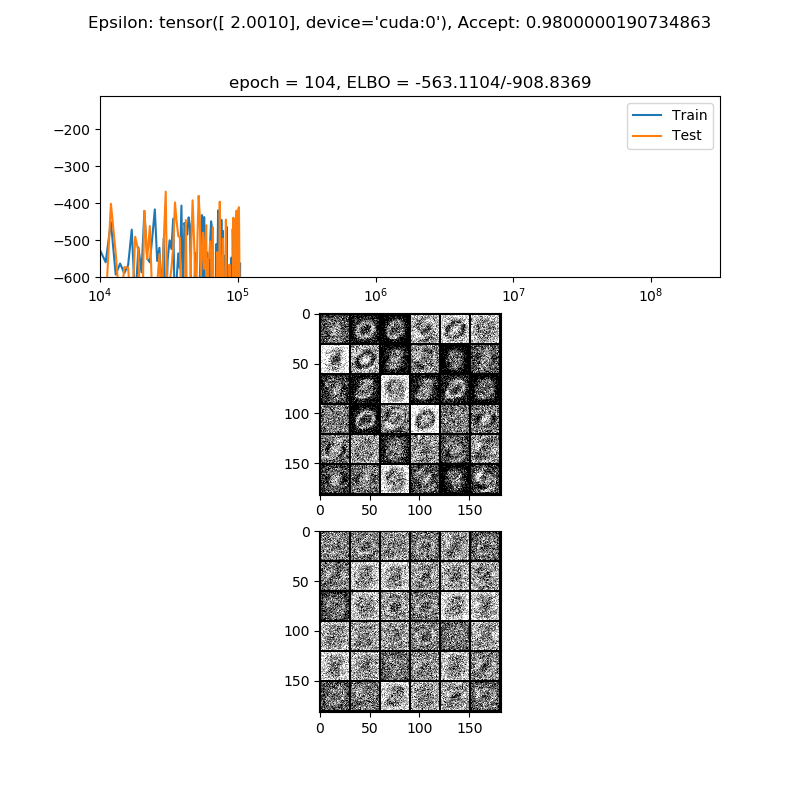

=> found checkpoint 'mcem9-784-3-100-0.0200'.
=> loaded checkpoint 'checkpoints/mcem9-784-3-100-0.0200' (epoch 104)


In [44]:
# model parameters
D = 784
Nz = 3
hidden_dim = 100
epochs = 105
l_rate = 0.02
model = VariationalAutoEncodeBernoulli(D, hidden_dim, Nz, D).to(device)
run = 'mcem9-{0:d}-{1:d}-{2:d}-{3:.4f}'.format(D, Nz, hidden_dim, l_rate)

# plot setup
fig, ax = plt.subplots(3,1,figsize=(8,8))
fig.suptitle('run: {}'.format(run))
ax[0].ticklabel_format(axis='x',style='sci',scilimits=(-3,4))
#ax[0].set_aspect('equal', 'datalim')
ax[0].set_xscale("symlog")
ax[0].set_ylim(-600, -110)
ax[0].set_xlim(10**4, 10**8.5)

mcem_mnist_vaeb = train_mcem(
    run, 
    model, 
    l_rate, 
    0.001,
    epochs, 
    1000, 
    em_mnist_train_images, 
    em_mnist_test_images, 
    (1,28,28), 
    fig, 
    ax, 
    1
)

## Marginal Probability estimation

<IPython.core.display.Javascript object>


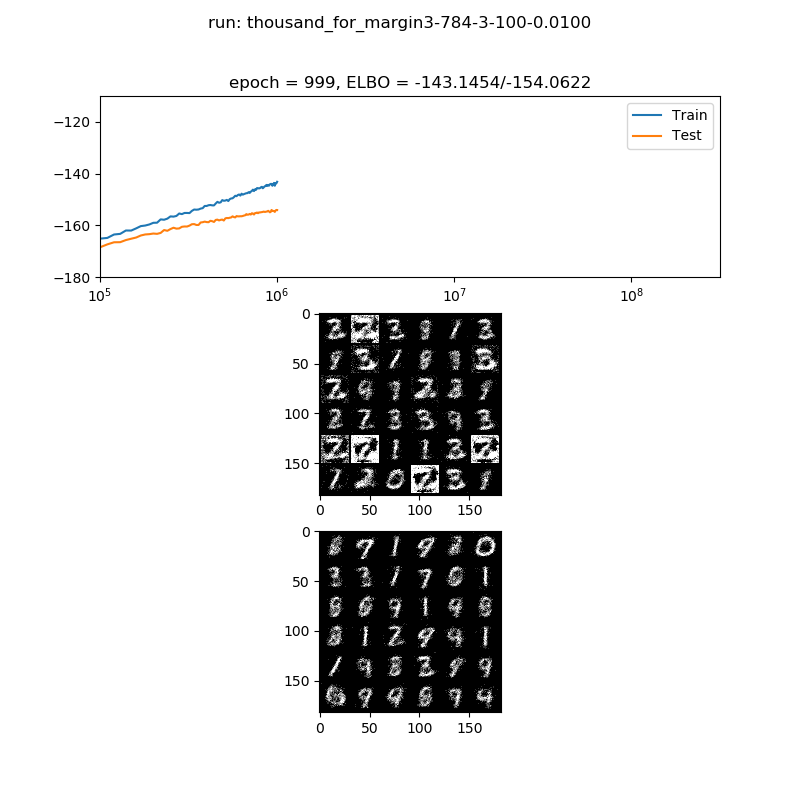

=> found checkpoint 'checkpoints/thousand_for_margin3-784-3-100-0.0100'.
=> loaded checkpoint 'checkpoints/thousand_for_margin3-784-3-100-0.0100' (epoch 161)


In [46]:
# model training setup for marginal likelihood estimation

# model parameters
D = 784
Nz = 3
hidden_dim = 100
epochs = 1000
l_rate = 0.01
model = VariationalAutoEncodeBernoulli(D, hidden_dim, Nz, D).to(device)
run = 'thousand_for_margin3-{0:d}-{1:d}-{2:d}-{3:.4f}'.format(D, Nz, hidden_dim, l_rate)

# plot setup
fig, ax = plt.subplots(3,1,figsize=(8,8))
fig.suptitle('run: {}'.format(run))
ax[0].ticklabel_format(axis='x',style='sci',scilimits=(-3,4))
#ax[0].set_aspect('equal', 'datalim')
ax[0].set_xscale("symlog")
ax[0].set_ylim(-180, -110)
ax[0].set_xlim(10**5, 10**8.5)

mnist_vaeb = train(
    run, 
    model, 
    l_rate, 
    epochs, 
    100, 
    em_mnist_train_images, 
    em_mnist_test_images, 
    (1,28,28), 
    fig, 
    ax, 
    10
)

In [47]:
def marginal_likelihood(model, images):
    # stochastically estimate marginal likelihood of model
    num_samples = len(images)
    x=images
    phi = torch.Tensor([0]).to(device)
    
    samples, likelihoods, accept = sample_posterior(model, x, 300, 4, 0.005, phi, False, (1,28,28))
        
    # use warmed-up samples 
    density_z = samples[-25:]
    density_likelihoods = likelihoods[-25:]
    estimation_z = samples[-50:-25]
    estimation_likelihoods = likelihoods[-50:-25]
    
    estimates = np.ones(num_samples)
    log_sample_densities = np.array([
        KernelDensity(kernel='gaussian', bandwidth=0.5).fit(density_z[:,i]).score_samples(estimation_z[:,i])
        for i in np.arange(estimation_z.shape[1])
    ])
    logsum = logsumexp(
        log_sample_densities.T - estimation_likelihoods.detach().cpu().numpy(),
        axis=0
    )
    estimates = -(logsum - np.log(num_samples))
    print(estimates.mean())
    return estimates.mean()


<IPython.core.display.Javascript object>


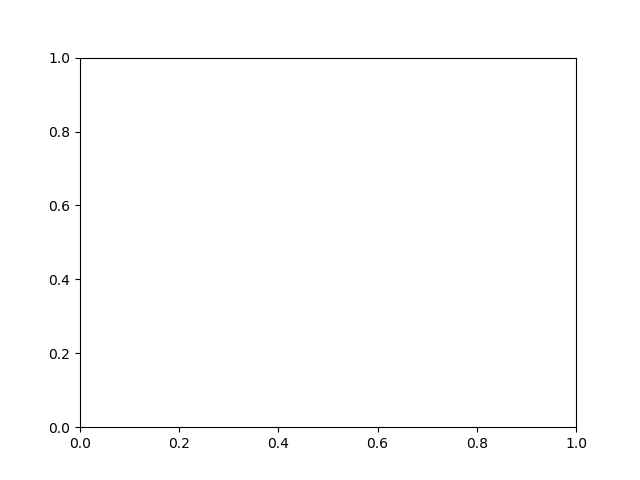

=> no checkpoint found at 'checkpoints/thousand_for_margin2-784-3-100-0.0100'


In [49]:
checkpoint_folder = 'checkpoints/thousand_for_margin2-784-3-100-0.0100'
model = VariationalAutoEncodeBernoulli(D, 100, 3, D).to(device)
fig, ax = plt.subplots(1,1, sharex=True)
if os.path.isdir(checkpoint_folder):
    print("=> found checkpoint '{}'.".format(checkpoint_folder))
    dirFiles = list(filter(lambda f: re.match('checkpoint', f), os.listdir(checkpoint_folder)))
    dirFiles.sort()
    
    loss_checkpoint = torch.load(os.path.join(checkpoint_folder,'losses.pth.tar'))
    tr_losses = loss_checkpoint['tr_losses']
    te_losses = loss_checkpoint['te_losses']
    epoch_size = loss_checkpoint['batch_size']
    report_interval = loss_checkpoint['report_interval']
    
    train_marginals = np.zeros(len(tr_losses))
    test_marginals = np.zeros(len(tr_losses))
    start_i = 0
    i = start_i
    #ax.set_ylim(-190,-0)
    ax.set_xlim(0,len(te_losses)*1000*10)
    ax.ticklabel_format(axis='x',style='sci', scilimits=(0,0))
    ax.plot(np.arange(len(tr_losses))*1000*10, tr_losses)
    ax.plot(np.arange(len(te_losses))*1000*10, te_losses)
    l1, = ax.plot([],[])
    l2, = ax.plot([],[])
    for file in dirFiles[i::100]:
        checkpoint = torch.load(os.path.join(checkpoint_folder, file))
        epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        # split eval to avoid running out of GPU memory
        train_marginals[i] += marginal_likelihood(model, em_mnist_train_images[0:1000])
        test_marginals[i] += marginal_likelihood(model, em_mnist_test_images[0:1000])
        l1.set_data(np.arange(start_i,i+1)*epoch_size*report_interval*100, train_marginals[start_i:i+1])
        l2.set_data(np.arange(start_i,i+1)*epoch_size*report_interval*100, test_marginals[start_i:i+1])
        print(np.arange(start_i,i+1)*epoch_size*report_interval*10)
        fig.canvas.draw()
        time.sleep(0.01)
        i += 1
else:
    print("=> no checkpoint found at '{}'".format(checkpoint_folder))
    os.makedirs(checkpoint_folder)

In [ ]:
norm.logpdf(5.7)